In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv

In [10]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', 
                                 root='../../data/dataset/',
                                 transform=T.ToSparseTensor())

Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18724.57it/s]


Converting graphs into PyG objects...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2247.75it/s]

Saving...



Done!


In [11]:
torch.cuda.is_available()

True

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [13]:
data = dataset[0]

In [14]:
evaluator = Evaluator(name='ogbn-arxiv')

In [15]:
data

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])

In [16]:
adj_t = data['adj_t']

In [62]:
adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169341, 169341]),
             col=tensor([   411,    640,   1162,  ...,  30351,  35711, 103121]),
             size=(169343, 169343), nnz=1166243, density=0.00%)

In [18]:
n_quotes = adj_t.sum(dim=0)
n_quoted = adj_t.sum(dim=1)
n_total_quotes = adj_t.to_symmetric().sum(dim=1)

In [19]:
df = pd.DataFrame({
    'year' : data['node_year'][:, 0],
    'n_quoted' : n_quoted,
    'n_quotes' : n_quotes,
    'n_total_quotes' : n_total_quotes
})

In [20]:
df.head()

,year,n_quoted,n_quotes,n_total_quotes
0,2013,289.0,2.0,291.0
1,2015,1.0,1.0,2.0
2,2014,5.0,9.0,14.0
3,2014,2.0,0.0,2.0
4,2014,5.0,1.0,6.0


## Distribution over time

<AxesSubplot:xlabel='year'>

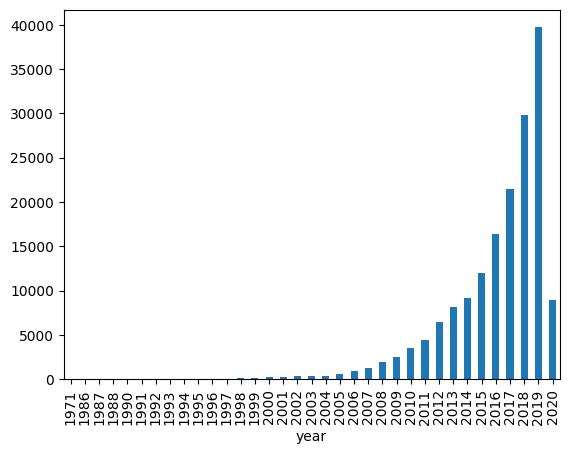

In [21]:
df.groupby('year')['n_quoted'].count().plot(kind='bar')

## Cited by number

In [22]:
col = 'n_quoted'

In [23]:
df[col].describe()

count    169343.000000
mean          6.886868
std          67.599319
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max       13155.000000
Name: n_quoted, dtype: float64

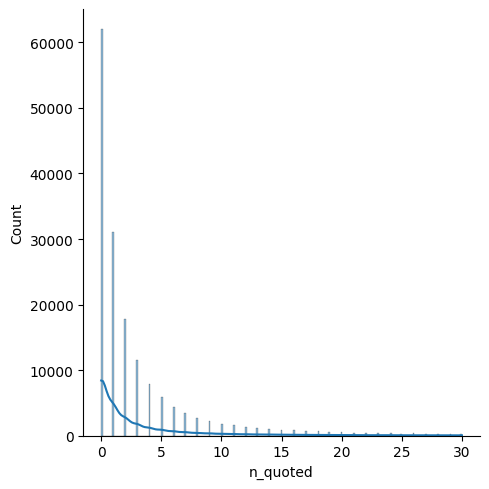

In [24]:
xmax = 30
mask = df[col] <= xmax
sns.displot(df.loc[mask, col], kde=True)

(0.0, 30.0)

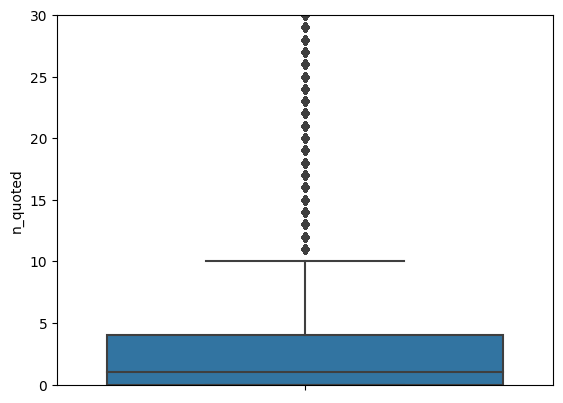

In [25]:
sns.boxplot(data=df, y=col, orient='v')
plt.ylim(0, xmax)

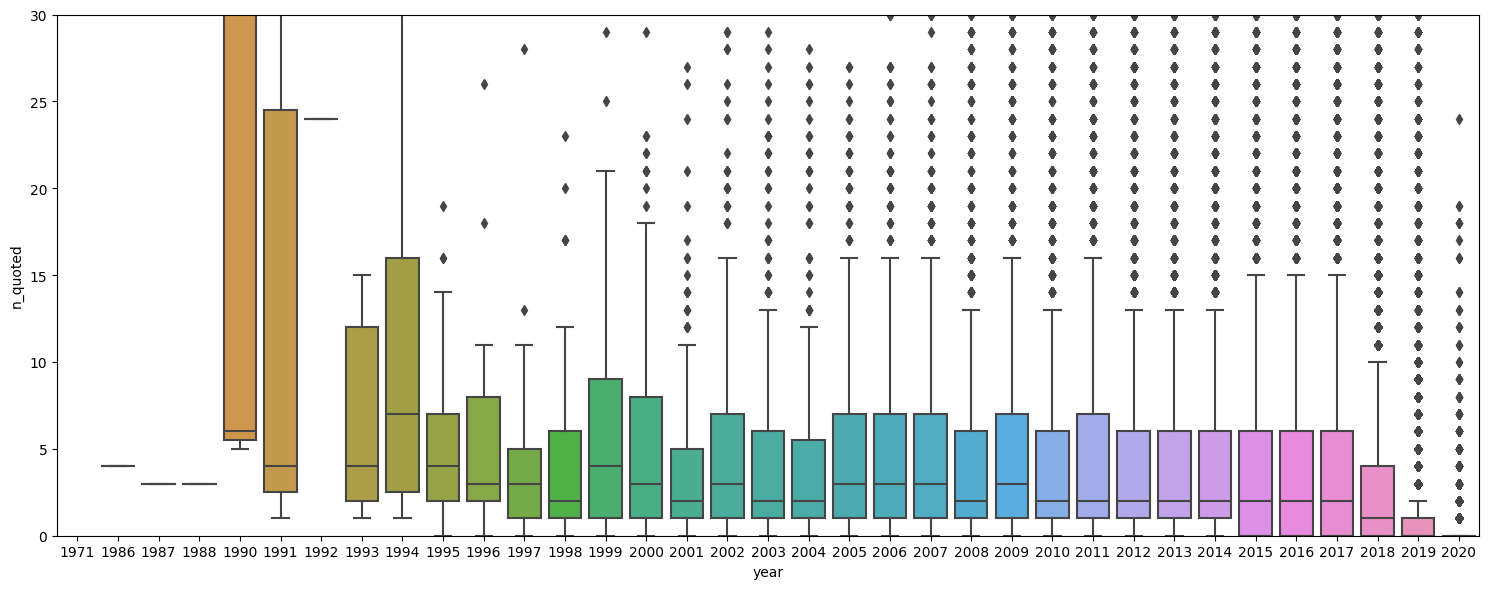

In [26]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='year', y=col, orient='v')
plt.ylim(0, xmax)
plt.tight_layout()

## Cites number

In [27]:
col = 'n_quotes'

In [28]:
df[col].describe()

count    169343.000000
mean          6.886868
std           8.879428
min           0.000000
25%           1.000000
50%           4.000000
75%           9.000000
max         436.000000
Name: n_quotes, dtype: float64

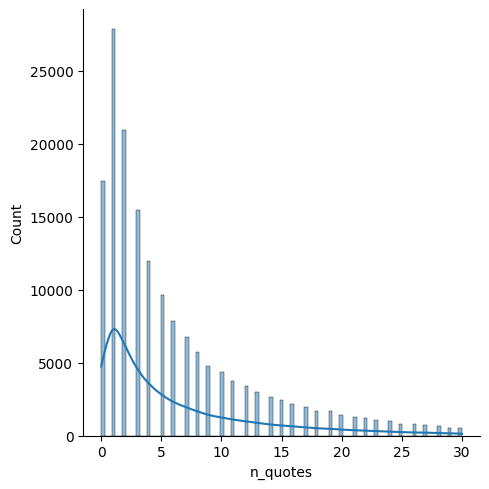

In [29]:
xmax = 30
mask = df[col] <= xmax
sns.displot(df.loc[mask, col], kde=True)

(0.0, 30.0)

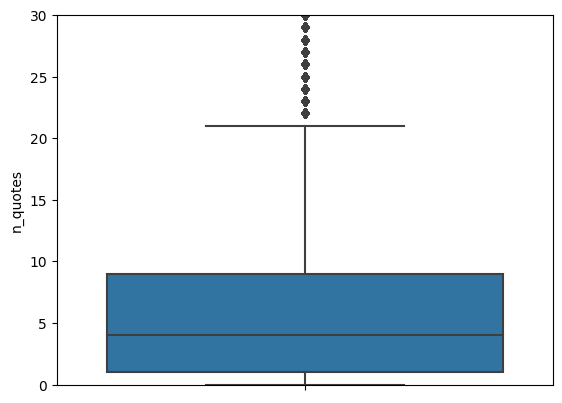

In [30]:
sns.boxplot(data=df, y=col, orient='v')
plt.ylim(0, xmax)

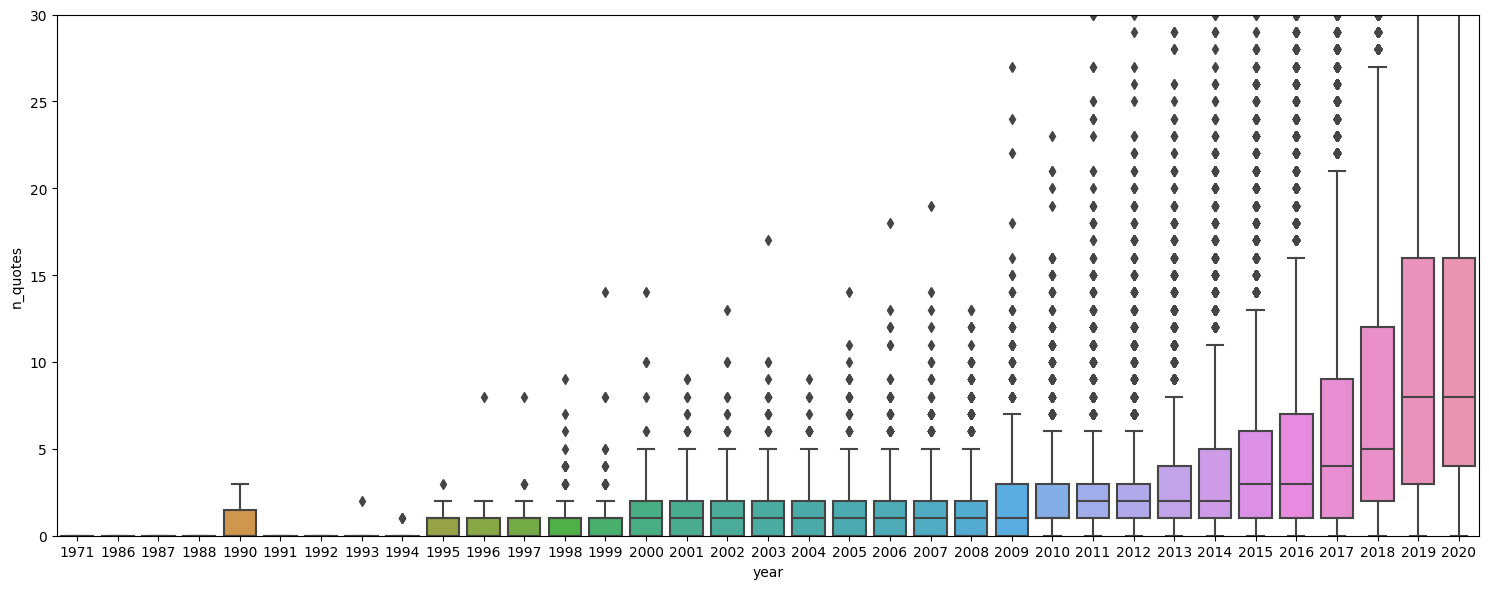

In [31]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='year', y=col, orient='v')
plt.ylim(0, xmax)
plt.tight_layout()

## Distribution over simmetric matrix

In [32]:
df[df['n_quoted'] + df['n_quotes'] != df['n_total_quotes']].shape

(12409, 4)

In [33]:
col = 'n_total_quotes'

In [34]:
df[col].describe()

count    169343.000000
mean         13.674010
std          68.638313
min           1.000000
25%           3.000000
50%           6.000000
75%          14.000000
max       13161.000000
Name: n_total_quotes, dtype: float64

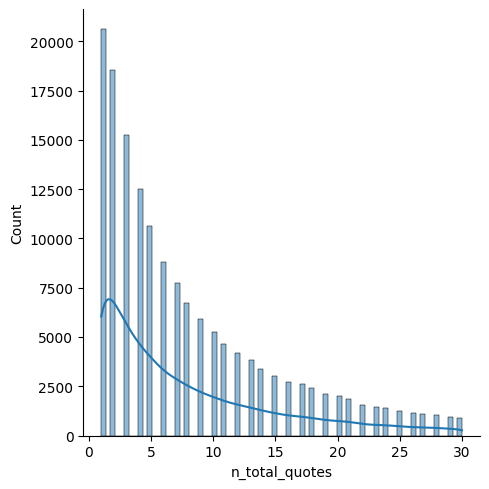

In [35]:
xmax = 30
mask = df[col] <= xmax
sns.displot(df.loc[mask, col], kde=True)

In [46]:
degree_counts = df.groupby('n_total_quotes')['year'].count().sort_index()

Text(0.5, 1.0, 'Degree Distribution')

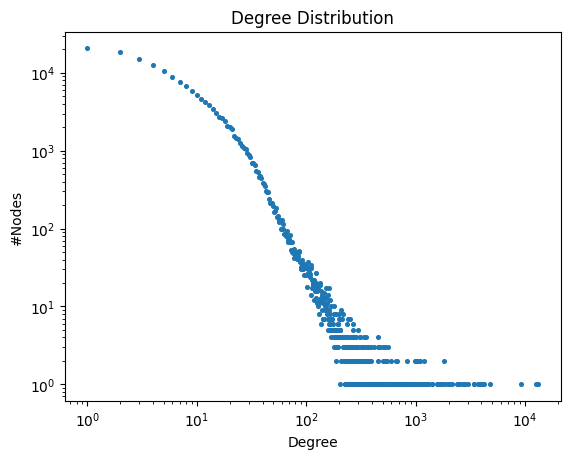

In [61]:
degree_counts\
    .rename_axis('Degree')\
    .rename('#Nodes')\
    .reset_index()\
    .plot(
        kind='scatter',
        x='Degree',
        y='#Nodes',
        s=7)

plt.yscale('log')
plt.xscale('log')

plt.title('Degree Distribution')

(0.0, 30.0)

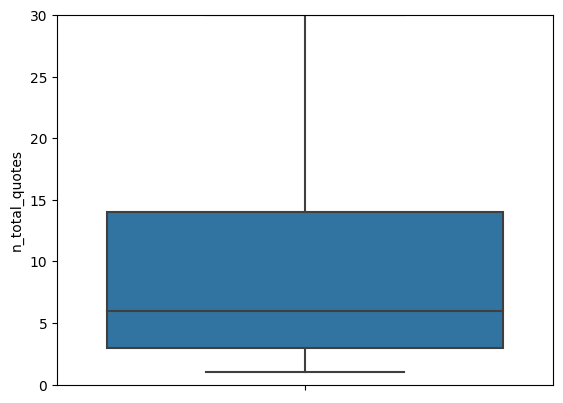

In [36]:
sns.boxplot(data=df, y=col, orient='v')
plt.ylim(0, xmax)

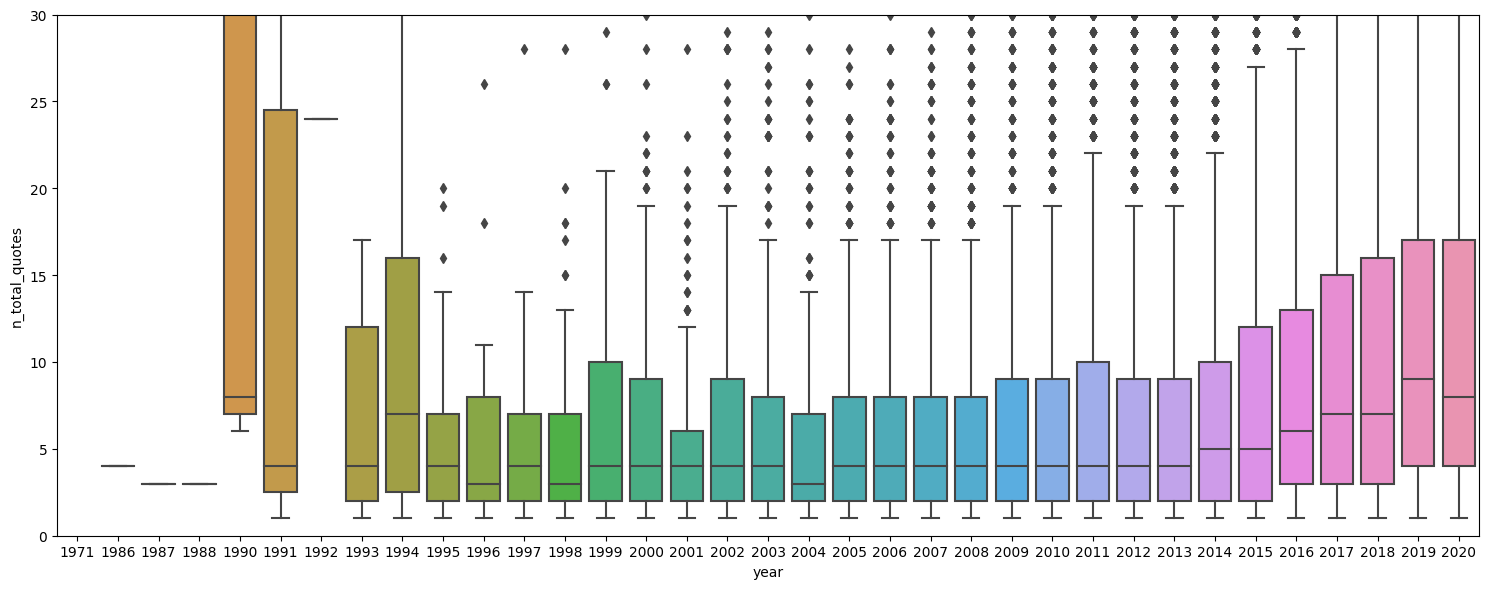

In [37]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='year', y=col, orient='v')
plt.ylim(0, xmax)
plt.tight_layout()